### Multidimensional GP

Until now, our examples have been of 1-dimensional Gaussian processes, where there is just a single predictor variable thought to have a non-linear relationship to the outcome. Let's look at a real-world dataset that involves two predictors. We will use the famous **Walker Lake dataset (Isaaks & Srivistava 1989)** that involves spatial sampling of minerals and other variables over space. The data consist of two spatial coordinates and three measured outcomes. The outcomes are anonymously labeled as U, V (continuous variables, such as concentrarion) and T (discrete variable, such as the presence of a particular element). 

In [5]:
import os

os.environ["MKL_NUM_THREADS"] = "1"
os.environ["OPENBLAS_NUM_THREADS"] = "1"

In [6]:
%matplotlib inline
import warnings

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc3 as pm
import seaborn as sns

warnings.simplefilter("ignore")

In [7]:
walker_data = pd.read_table(
    "../data/walker.txt",
    sep=r"\s+",
    index_col=0,
    skiprows=8,
    header=None,
    names=["ID", "Xloc", "Yloc", "V", "U", "T"],
)
walker_data.head()

,Xloc,Yloc,V,U,T
ID,,,,,
1,11,8,0.0,1.000000e+31,2
2,8,30,0.0,1.000000e+31,2
3,9,48,224.4,1.000000e+31,2
4,8,69,434.4,1.000000e+31,2
5,9,90,412.1,1.000000e+31,2


The samples are taken regularly over a coarse grid across the entire area, and then irregularly over portions of the area, presumably where there were positive samples on the coarser grid. 

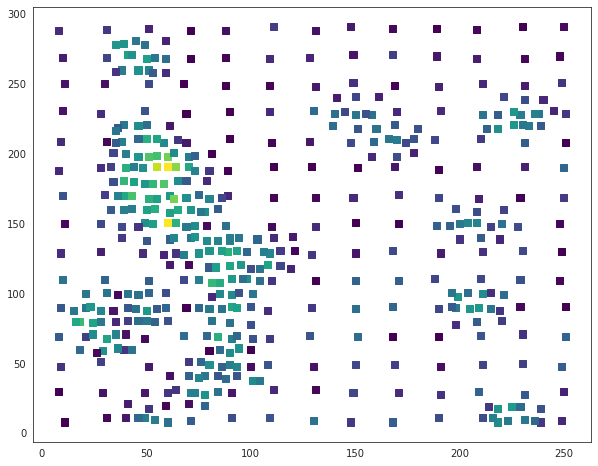

In [8]:
nx = 40
x1, x2 = np.meshgrid(np.linspace(0, 300, nx), np.linspace(0, 300, nx))
X = np.concatenate([x1.reshape(nx * nx, 1), x2.reshape(nx * nx, 1)], 1)

X_obs = walker_data[["Xloc", "Yloc"]].values
y_obs = walker_data.V.values

with sns.axes_style("white"):
    plt.figure(figsize=(10, 8))
    plt.scatter(
        X_obs[:, 0], X_obs[:, 1], s=50, c=y_obs, marker="s", cmap=plt.cm.viridis
    );

We need a sparse grid of inducing points:

In [9]:
nd = 15
xu1, xu2 = np.meshgrid(np.linspace(0, 300, nd), np.linspace(0, 300, nd))
Xu = np.concatenate([xu1.reshape(nd * nd, 1), xu2.reshape(nd * nd, 1)], 1)

In [10]:
with pm.Model() as spatial_model:

    l = pm.HalfCauchy("l", beta=3, shape=(2,))
    sf2 = pm.HalfCauchy("sf2", beta=3)
    sn2 = pm.HalfCauchy("sn2", beta=3)

    K = pm.gp.cov.ExpQuad(2, l) * sf2 ** 2

    gp_spatial = pm.gp.MarginalSparse(cov_func=K, approx="FITC")
    obs = gp_spatial.marginal_likelihood("obs", X=X_obs, Xu=Xu, y=y_obs, noise=sn2)

    mp = pm.find_MAP()

In [11]:
nd = 30
z1, z2 = np.meshgrid(np.linspace(0, 300, nd), np.linspace(0, 300, nd))
Z = np.concatenate([z1.reshape(nd * nd, 1), z2.reshape(nd * nd, 1)], 1)

In [12]:
with spatial_model:
    f_pred = gp_spatial.conditional("f_pred", Z)
    samples = pm.sample_posterior_predictive([mp], vars=[f_pred], samples=100)

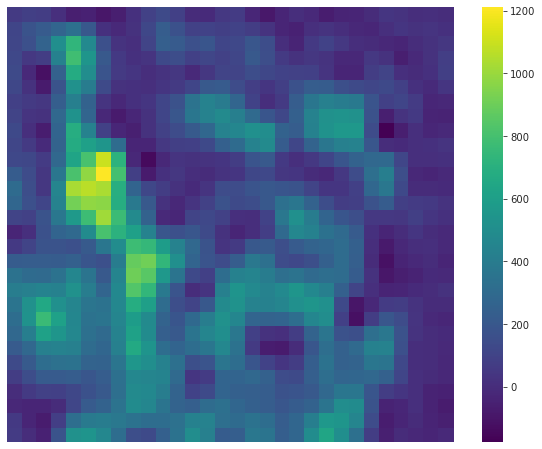

In [13]:
with sns.axes_style("white"):
    plt.figure(figsize=(10, 8))
    ax = sns.heatmap(samples["f_pred"].mean(0).reshape(nd, nd), cmap="viridis")
    ax.invert_yaxis()
    ax.set_yticklabels([])
    ax.set_xticklabels([])